# The Double Descent Phenomenon

## Introduction

This notebook explores one of the most surprising discoveries in modern machine learning: **the double descent phenomenon**.

### The Classical View (U-shaped Bias-Variance Tradeoff)

Traditional statistical learning theory tells us:
- **Underparameterized models** (few parameters): High bias, low variance → underfitting
- **Sweet spot**: Optimal balance between bias and variance
- **Overparameterized models** (many parameters): Low bias, high variance → overfitting

This creates a **U-shaped test error curve** as model complexity increases.

### The Modern Discovery (Double Descent)

Recent research has shown that **test error can decrease again** in the heavily overparameterized regime!

The curve has **two descents**:
1. **First descent**: Classical regime (increasing parameters up to n)
2. **Peak**: Interpolation threshold (parameters ≈ samples)
3. **Second descent**: Modern regime (parameters >> samples)

### What We'll Explore:
1. **Linear Regression**: Demonstrate double descent with varying feature counts
2. **Neural Networks**: Show the phenomenon on Fashion-MNIST
3. **Analysis**: Understand why this happens and its implications


## Setup: Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../../../')

# Import our utility functions
from src.dlf.theory.double_descent import (
    generate_linear_regression_data,
    fit_least_squares,
    fit_minimum_norm,
    compute_risk,
    double_descent_experiment,
    load_fashion_mnist,
    FullyConnectedNet,
    train_neural_network
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Part 1: Double Descent in Linear Regression

### The Setup

We'll study the linear model:
$$y = X\beta + \epsilon$$

where:
- $X \in \mathbb{R}^{n \times p}$: design matrix (n samples, p features)
- $\beta \in \mathbb{R}^p$: true coefficients with decay $\beta_j \sim 1/j^2$
- $\epsilon \sim \mathcal{N}(0, \sigma^2)$: Gaussian noise

### Two Estimation Methods

**1. Classical Least Squares** (when p < n):
$$\hat{\beta} = (X^T X)^{-1} X^T y$$

**2. Minimum-Norm Interpolator** (when p ≥ n):
$$\hat{\beta} = X^T (X X^T)^{-1} y$$

This is the **minimum L2 norm solution** among all solutions that perfectly fit the training data.

### Key Insight

As we vary p (number of features):
- **p < n**: Use least squares, test error decreases
- **p = n**: Interpolation threshold, test error peaks
- **p > n**: Use minimum-norm, test error decreases again (double descent!)

### Run Linear Regression Experiment

We'll test with:
- n = 100 training samples
- d = 200 total features
- p varying from 10 to 150
- 50 random trials for each p

In [3]:
print("="*80)
print("PART 1: LINEAR REGRESSION DOUBLE DESCENT")
print("="*80)

# Define feature counts to test
p_values = list(range(10, 151, 5))

# Run the experiment
results_linear = double_descent_experiment(
    n=100,
    d=200,
    p_values=p_values,
    sigma=0.2,
    n_trials=50,
    seed=SEED
)

print("\n✓ Linear regression experiment complete!")

PART 1: LINEAR REGRESSION DOUBLE DESCENT

Running experiment with n=100, d=200, sigma=0.2
Number of trials: 50
Testing 29 different feature counts from 10 to 150
--------------------------------------------------------------------------------
p= 20: Train Risk=0.682859, Test Risk=1.072918
p= 40: Train Risk=0.489673, Test Risk=1.492655
p= 60: Train Risk=0.313505, Test Risk=2.202249
p= 80: Train Risk=0.141767, Test Risk=3.435744
p=100: Train Risk=0.000000, Test Risk=15155.376910
p=120: Train Risk=0.000000, Test Risk=3.399971
p=140: Train Risk=0.000000, Test Risk=1.816304

✓ Linear regression experiment complete!


p= 40: Train Risk=0.489673, Test Risk=1.492655
p= 60: Train Risk=0.313505, Test Risk=2.202249


p= 80: Train Risk=0.141767, Test Risk=3.435744
p=100: Train Risk=0.000000, Test Risk=15155.376910


p=120: Train Risk=0.000000, Test Risk=3.399971
p=140: Train Risk=0.000000, Test Risk=1.816304



✓ Linear regression experiment complete!


### Visualize Linear Regression Double Descent

We'll create two plots:
1. **Log-log scale**: Shows the overall trend
2. **Linear scale**: Shows details and annotated regions

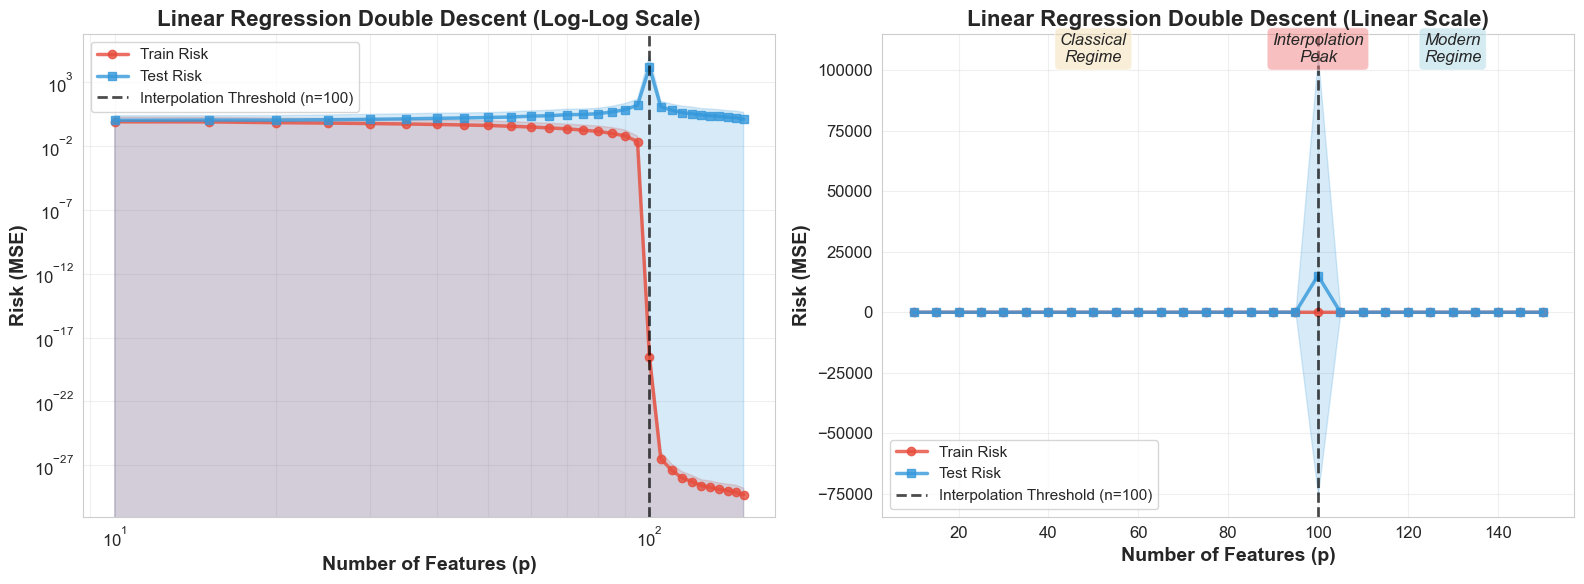

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extract results
p_vals = results_linear['p_values']
train_risks = results_linear['train_risks']
test_risks = results_linear['test_risks']
train_std = results_linear['train_risks_std']
test_std = results_linear['test_risks_std']

# Plot 1: Log-log scale
ax1 = axes[0]
ax1.plot(p_vals, train_risks, 'o-', label='Train Risk',
         linewidth=2.5, markersize=6, color='#e74c3c', alpha=0.8)
ax1.plot(p_vals, test_risks, 's-', label='Test Risk',
         linewidth=2.5, markersize=6, color='#3498db', alpha=0.8)

# Add confidence intervals
ax1.fill_between(p_vals,
                 np.array(train_risks) - np.array(train_std),
                 np.array(train_risks) + np.array(train_std),
                 alpha=0.2, color='#e74c3c')
ax1.fill_between(p_vals,
                 np.array(test_risks) - np.array(test_std),
                 np.array(test_risks) + np.array(test_std),
                 alpha=0.2, color='#3498db')

# Mark interpolation threshold
ax1.axvline(x=100, color='black', linestyle='--', linewidth=2,
            alpha=0.7, label='Interpolation Threshold (n=100)')

ax1.set_xlabel('Number of Features (p)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Risk (MSE)', fontsize=14, fontweight='bold')
ax1.set_title('Linear Regression Double Descent (Log-Log Scale)',
              fontsize=16, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3, which='both')

# Plot 2: Linear scale with annotations
ax2 = axes[1]
ax2.plot(p_vals, train_risks, 'o-', label='Train Risk',
         linewidth=2.5, markersize=6, color='#e74c3c', alpha=0.8)
ax2.plot(p_vals, test_risks, 's-', label='Test Risk',
         linewidth=2.5, markersize=6, color='#3498db', alpha=0.8)

# Add confidence intervals
ax2.fill_between(p_vals,
                 np.array(train_risks) - np.array(train_std),
                 np.array(train_risks) + np.array(train_std),
                 alpha=0.2, color='#e74c3c')
ax2.fill_between(p_vals,
                 np.array(test_risks) - np.array(test_std),
                 np.array(test_risks) + np.array(test_std),
                 alpha=0.2, color='#3498db')

# Mark interpolation threshold
ax2.axvline(x=100, color='black', linestyle='--', linewidth=2,
            alpha=0.7, label='Interpolation Threshold (n=100)')

# Annotate key regions
y_pos = ax2.get_ylim()[1] * 0.9
ax2.annotate('Classical\nRegime', xy=(50, y_pos),
             fontsize=12, ha='center', style='italic',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.annotate('Interpolation\nPeak', xy=(100, y_pos),
             fontsize=12, ha='center', style='italic',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))
ax2.annotate('Modern\nRegime', xy=(130, y_pos),
             fontsize=12, ha='center', style='italic',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

ax2.set_xlabel('Number of Features (p)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Risk (MSE)', fontsize=14, fontweight='bold')
ax2.set_title('Linear Regression Double Descent (Linear Scale)',
              fontsize=16, fontweight='bold')
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('linear_double_descent.png', dpi=150, bbox_inches='tight')
plt.show()

### Analyze Linear Regression Results

In [5]:
# Find key points
interpolation_idx = p_vals.index(100)
min_test_underfit = np.min(test_risks[:interpolation_idx])
max_test_peak = test_risks[interpolation_idx]
min_test_overfit = np.min(test_risks[interpolation_idx:])

print("\n" + "="*80)
print("LINEAR REGRESSION KEY FINDINGS")
print("="*80)
print(f"\n📊 Experimental Setup:")
print(f"   • Training samples: n = 100")
print(f"   • Feature pool: d = 200")
print(f"   • Tested p values: {min(p_vals)} to {max(p_vals)}")
print(f"   • Trials per p: 50")

print(f"\n🎯 Three Regimes:")
print(f"   1. Classical (p < n=100):")
best_classical_idx = np.argmin(test_risks[:interpolation_idx])
print(f"      Best at p={p_vals[best_classical_idx]}, Test Risk={min_test_underfit:.6f}")

print(f"\n   2. Interpolation Threshold (p = n=100):")
print(f"      Test Risk peaks at {max_test_peak:.6f}")
print(f"      This is {(max_test_peak/min_test_underfit - 1)*100:.1f}% worse than best classical")

print(f"\n   3. Modern Regime (p > n=100):")
best_modern_idx = interpolation_idx + np.argmin(test_risks[interpolation_idx:])
print(f"      Best at p={p_vals[best_modern_idx]}, Test Risk={min_test_overfit:.6f}")
print(f"      Recovery: {(max_test_peak - min_test_overfit)/max_test_peak * 100:.1f}% reduction from peak")

print(f"\n✨ Double Descent Observed:")
print(f"   Test error decreases → peaks at p=n → decreases again!")
print(f"   Modern regime achieves comparable or better performance than classical regime.")


LINEAR REGRESSION KEY FINDINGS

📊 Experimental Setup:
   • Training samples: n = 100
   • Feature pool: d = 200
   • Tested p values: 10 to 150
   • Trials per p: 50

🎯 Three Regimes:
   1. Classical (p < n=100):
      Best at p=10, Test Risk=1.036469

   2. Interpolation Threshold (p = n=100):
      Test Risk peaks at 15155.376910
      This is 1462111.9% worse than best classical

   3. Modern Regime (p > n=100):
      Best at p=150, Test Risk=1.249233
      Recovery: 100.0% reduction from peak

✨ Double Descent Observed:
   Test error decreases → peaks at p=n → decreases again!
   Modern regime achieves comparable or better performance than classical regime.


## Part 2: Double Descent in Neural Networks

### The Setup

We'll demonstrate double descent on **Fashion-MNIST**:
- **Task**: Image classification (10 classes)
- **Input**: 28×28 grayscale images (784 features)
- **Architecture**: Fully connected network with 2 hidden layers
- **Variable**: Width of hidden layers

### Architecture

```
Input (784) → Hidden1 (width) → Hidden2 (width) → Output (10)
```

We'll vary the width and observe:
- Small width: Underfitting
- Medium width: Interpolation threshold (training accuracy ~100%)
- Large width: Overparameterized, but test accuracy improves again!

### Load Fashion-MNIST Dataset

In [6]:
print("="*80)
print("PART 2: NEURAL NETWORK DOUBLE DESCENT")
print("="*80)

print("\nLoading Fashion-MNIST dataset...")
train_dataset, test_dataset = load_fashion_mnist(subset_size=1000, test_size=500)
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("\nClasses: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot")

PART 2: NEURAL NETWORK DOUBLE DESCENT

Loading Fashion-MNIST dataset...


100%|██████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 11.5MB/s]
100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 285kB/s]
100%|██████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 5.25MB/s]
100%|███████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 973kB/s]

Training samples: 1000
Test samples: 500

Classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


### Visualize Sample Images

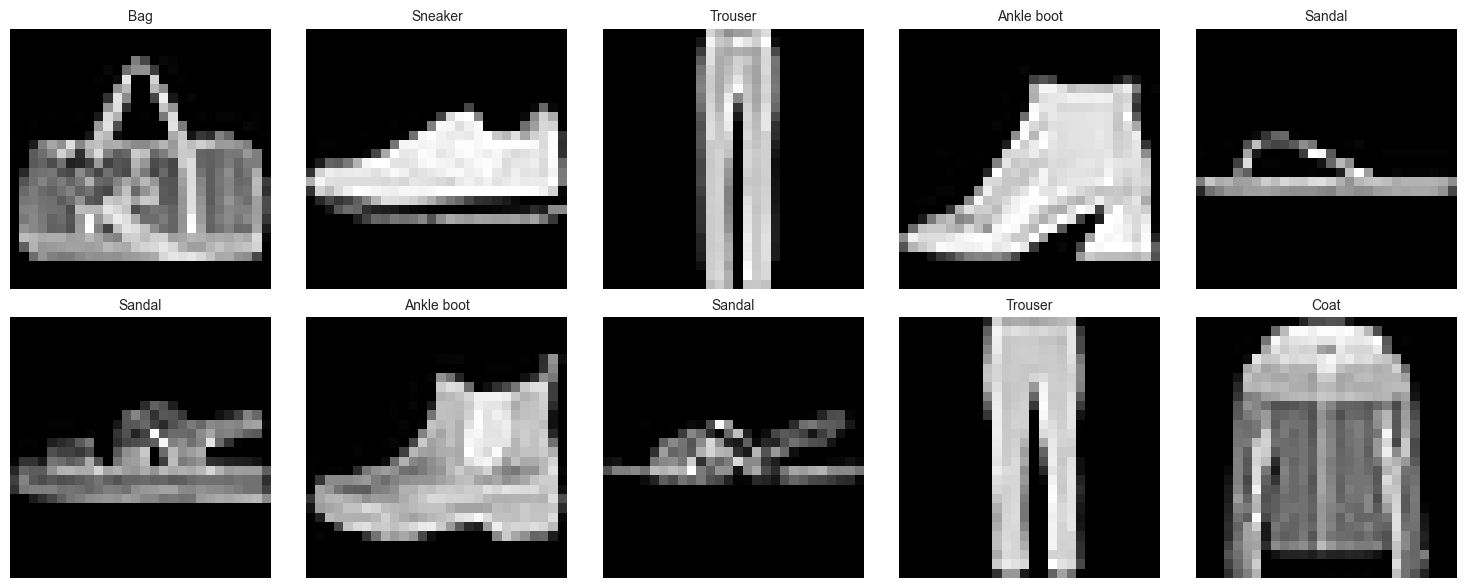

In [7]:
# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'{class_names[label]}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('fashion_mnist_samples.png', dpi=150, bbox_inches='tight')
plt.show()

### Train Networks with Different Widths

We'll train networks with varying widths from 5 to 2000 neurons per layer.

**Note**: This will take several minutes. Progress is printed for each width.

In [8]:
print("\nRunning Neural Network Double Descent Experiment...")
print("-" * 80)

# Define various widths to test
widths = [5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 300, 500, 750, 1000, 1500, 2000]
nn_results = []

for width in widths:
    print(f"\n[{widths.index(width)+1}/{len(widths)}] Training with width={width}...")
    
    # Create model with 2 hidden layers of same width
    model = FullyConnectedNet(
        input_dim=784,
        hidden_dims=[width, width],
        output_dim=10,
        activation='relu'
    )
    
    print(f"  Parameters: {model.count_parameters():,}")
    
    # Train model
    results = train_neural_network(
        model,
        train_dataset,
        test_dataset,
        epochs=100,
        batch_size=32,
        lr=0.001,
        patience=20,
        verbose=False,
        device=device
    )
    
    nn_results.append(results)
    
    print(f"  Train Acc: {results['final_train_acc']:.2f}%")
    print(f"  Test Acc:  {results['final_test_acc']:.2f}%")
    print(f"  Time: {results['training_time']:.1f}s | Epochs: {results['epochs_trained']}")

print("\n✓ Neural network experiment complete!")


Running Neural Network Double Descent Experiment...
--------------------------------------------------------------------------------

[1/16] Training with width=5...
  Parameters: 4,015
  Train Acc: 87.20%
  Test Acc:  73.00%
  Time: 5.3s | Epochs: 56

[2/16] Training with width=10...
  Parameters: 8,070
  Train Acc: 93.60%
  Test Acc:  75.60%
  Time: 6.3s | Epochs: 66

[3/16] Training with width=15...
  Parameters: 12,175
  Train Acc: 93.70%
  Test Acc:  77.40%
  Time: 3.6s | Epochs: 38

[4/16] Training with width=20...
  Parameters: 16,330
  Train Acc: 96.40%
  Test Acc:  77.00%
  Time: 4.5s | Epochs: 47

[5/16] Training with width=30...
  Parameters: 24,790
  Train Acc: 96.40%
  Test Acc:  78.20%
  Time: 3.4s | Epochs: 35

[6/16] Training with width=50...
  Parameters: 42,310
  Train Acc: 100.00%
  Test Acc:  76.20%
  Time: 5.1s | Epochs: 48

[7/16] Training with width=75...
  Parameters: 65,335
  Train Acc: 99.70%
  Test Acc:  76.40%
  Time: 4.5s | Epochs: 42

[8/16] Training with

  Train Acc: 87.20%
  Test Acc:  73.00%
  Time: 5.7s | Epochs: 56

[2/16] Training with width=10...
  Parameters: 8,070


  Train Acc: 93.60%
  Test Acc:  75.60%
  Time: 6.8s | Epochs: 66

[3/16] Training with width=15...
  Parameters: 12,175


  Train Acc: 93.70%
  Test Acc:  77.40%
  Time: 3.9s | Epochs: 38

[4/16] Training with width=20...
  Parameters: 16,330


  Train Acc: 96.40%
  Test Acc:  77.00%
  Time: 5.0s | Epochs: 47

[5/16] Training with width=30...
  Parameters: 24,790


  Train Acc: 96.40%
  Test Acc:  78.20%
  Time: 3.8s | Epochs: 35

[6/16] Training with width=50...
  Parameters: 42,310


  Train Acc: 100.00%
  Test Acc:  76.20%
  Time: 5.5s | Epochs: 48

[7/16] Training with width=75...
  Parameters: 65,335


  Train Acc: 99.70%
  Test Acc:  76.40%
  Time: 4.9s | Epochs: 42

[8/16] Training with width=100...
  Parameters: 89,610


  Train Acc: 99.20%
  Test Acc:  76.40%
  Time: 3.6s | Epochs: 30

[9/16] Training with width=150...
  Parameters: 141,910


  Train Acc: 98.70%
  Test Acc:  76.20%
  Time: 3.7s | Epochs: 30

[10/16] Training with width=200...
  Parameters: 199,210


  Train Acc: 99.30%
  Test Acc:  77.40%
  Time: 3.9s | Epochs: 29

[11/16] Training with width=300...
  Parameters: 328,810


  Train Acc: 100.00%
  Test Acc:  78.40%
  Time: 4.1s | Epochs: 29

[12/16] Training with width=500...
  Parameters: 648,010


  Train Acc: 97.10%
  Test Acc:  76.20%
  Time: 5.6s | Epochs: 33

[13/16] Training with width=750...
  Parameters: 1,159,510


  Train Acc: 100.00%
  Test Acc:  77.80%
  Time: 11.3s | Epochs: 53

[14/16] Training with width=1000...
  Parameters: 1,796,010


  Train Acc: 100.00%
  Test Acc:  77.80%
  Time: 12.7s | Epochs: 48

[15/16] Training with width=1500...
  Parameters: 3,444,010


  Train Acc: 98.90%
  Test Acc:  74.40%
  Time: 15.5s | Epochs: 47

[16/16] Training with width=2000...
  Parameters: 5,592,010


  Train Acc: 100.00%
  Test Acc:  77.60%
  Time: 15.4s | Epochs: 39

✓ Neural network experiment complete!


### Visualize Neural Network Double Descent

We'll create four plots to analyze the double descent phenomenon:
1. **Accuracy vs Parameters**: Shows training and test accuracy
2. **Test Error vs Parameters**: Emphasizes the double descent curve
3. **Loss vs Parameters**: Cross-entropy loss curves
4. **Generalization Gap**: Difference between train and test accuracy

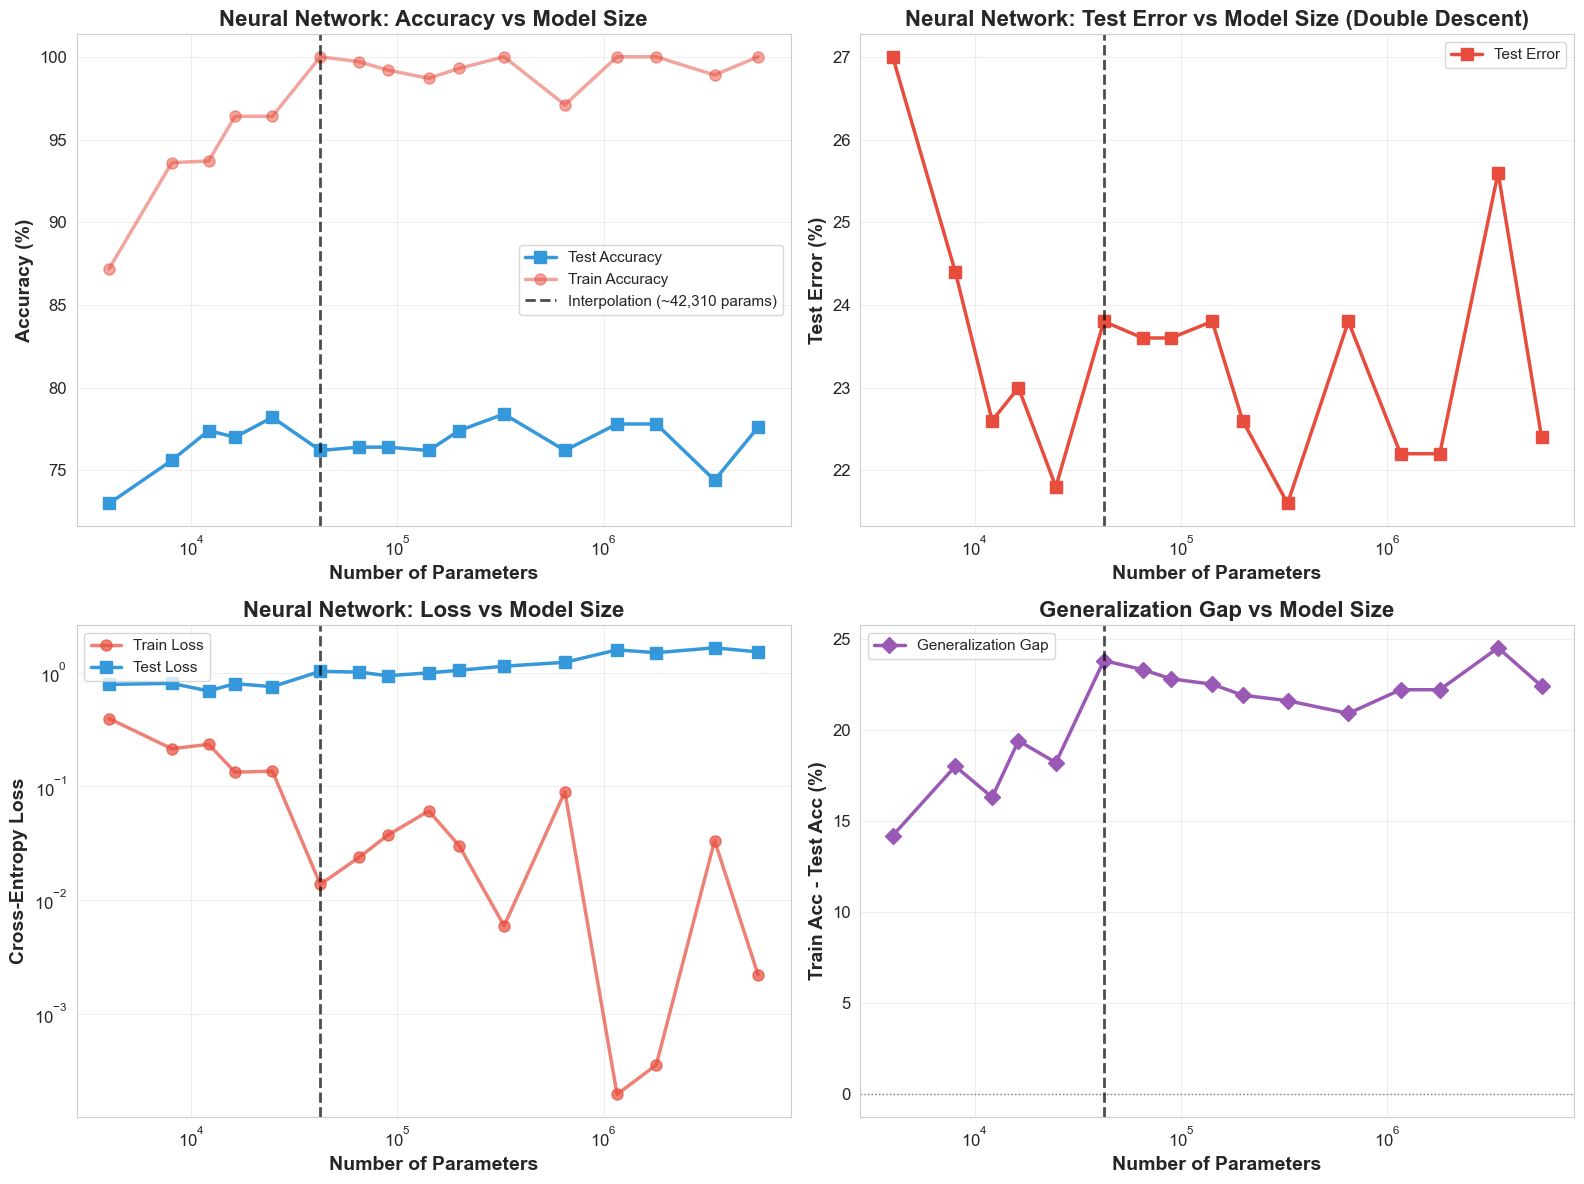

In [9]:
# Extract data
nn_params = [r['num_parameters'] for r in nn_results]
nn_train_acc = [r['final_train_acc'] for r in nn_results]
nn_test_acc = [r['final_test_acc'] for r in nn_results]
nn_train_loss = [r['history']['train_loss'][-1] for r in nn_results]
nn_test_loss = [r['history']['test_loss'][-1] for r in nn_results]

# Find interpolation threshold (where train accuracy reaches ~100%)
interpolation_threshold_idx = None
for i, acc in enumerate(nn_train_acc):
    if acc >= 99.0:
        interpolation_threshold_idx = i
        break

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Test Accuracy vs Parameters
ax1 = axes[0, 0]
ax1.plot(nn_params, nn_test_acc, 's-', linewidth=2.5, markersize=8,
         color='#3498db', label='Test Accuracy')
ax1.plot(nn_params, nn_train_acc, 'o-', linewidth=2.5, markersize=8,
         color='#e74c3c', alpha=0.5, label='Train Accuracy')

if interpolation_threshold_idx is not None:
    ax1.axvline(x=nn_params[interpolation_threshold_idx], color='black',
                linestyle='--', linewidth=2, alpha=0.7,
                label=f'Interpolation (~{nn_params[interpolation_threshold_idx]:,} params)')

ax1.set_xlabel('Number of Parameters', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Neural Network: Accuracy vs Model Size', fontsize=16, fontweight='bold')
ax1.set_xscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Test Error vs Parameters (double descent)
ax2 = axes[0, 1]
nn_test_error = [100 - acc for acc in nn_test_acc]
ax2.plot(nn_params, nn_test_error, 's-', linewidth=2.5, markersize=8,
         color='#e74c3c', label='Test Error')

if interpolation_threshold_idx is not None:
    ax2.axvline(x=nn_params[interpolation_threshold_idx], color='black',
                linestyle='--', linewidth=2, alpha=0.7)

ax2.set_xlabel('Number of Parameters', fontsize=14, fontweight='bold')
ax2.set_ylabel('Test Error (%)', fontsize=14, fontweight='bold')
ax2.set_title('Neural Network: Test Error vs Model Size (Double Descent)',
              fontsize=16, fontweight='bold')
ax2.set_xscale('log')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Loss curves
ax3 = axes[1, 0]
ax3.plot(nn_params, nn_train_loss, 'o-', linewidth=2.5, markersize=8,
         color='#e74c3c', label='Train Loss', alpha=0.7)
ax3.plot(nn_params, nn_test_loss, 's-', linewidth=2.5, markersize=8,
         color='#3498db', label='Test Loss')

if interpolation_threshold_idx is not None:
    ax3.axvline(x=nn_params[interpolation_threshold_idx], color='black',
                linestyle='--', linewidth=2, alpha=0.7)

ax3.set_xlabel('Number of Parameters', fontsize=14, fontweight='bold')
ax3.set_ylabel('Cross-Entropy Loss', fontsize=14, fontweight='bold')
ax3.set_title('Neural Network: Loss vs Model Size', fontsize=16, fontweight='bold')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Generalization gap
ax4 = axes[1, 1]
generalization_gap = [train - test for train, test in zip(nn_train_acc, nn_test_acc)]
ax4.plot(nn_params, generalization_gap, 'D-', linewidth=2.5, markersize=8,
         color='#9b59b6', label='Generalization Gap')
ax4.axhline(y=0, color='gray', linestyle=':', linewidth=1)

if interpolation_threshold_idx is not None:
    ax4.axvline(x=nn_params[interpolation_threshold_idx], color='black',
                linestyle='--', linewidth=2, alpha=0.7)

ax4.set_xlabel('Number of Parameters', fontsize=14, fontweight='bold')
ax4.set_ylabel('Train Acc - Test Acc (%)', fontsize=14, fontweight='bold')
ax4.set_title('Generalization Gap vs Model Size', fontsize=16, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neural_network_double_descent.png', dpi=150, bbox_inches='tight')
plt.show()

### Learning Curves for Selected Models

Let's examine the training dynamics of three representative models:
1. **Underparameterized**: Before interpolation threshold
2. **At Threshold**: Near interpolation point
3. **Overparameterized**: Deep into modern regime

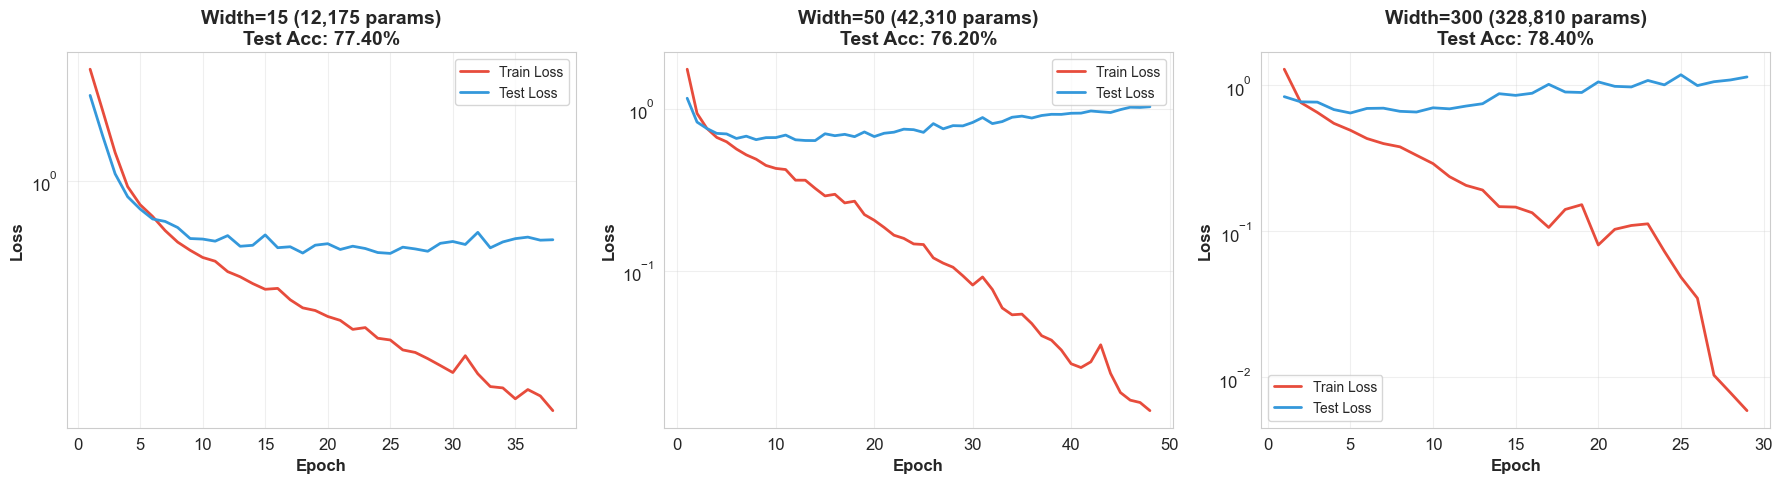

In [10]:
# Select 3 models
if interpolation_threshold_idx is not None:
    selected_indices = [
        max(0, interpolation_threshold_idx - 3),
        interpolation_threshold_idx,
        min(len(nn_results) - 1, interpolation_threshold_idx + 5)
    ]
else:
    selected_indices = [0, len(nn_results) // 2, len(nn_results) - 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, idx in enumerate(selected_indices):
    ax = axes[i]
    result = nn_results[idx]
    history = result['history']
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot losses
    ax.plot(epochs, history['train_loss'], label='Train Loss',
            linewidth=2, color='#e74c3c')
    ax.plot(epochs, history['test_loss'], label='Test Loss',
            linewidth=2, color='#3498db')
    
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_title(f'Width={widths[idx]} ({result["num_parameters"]:,} params)\n'
                f'Test Acc: {result["final_test_acc"]:.2f}%',
                fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig('neural_network_learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

### Analyze Neural Network Results

In [11]:
print("\n" + "="*80)
print("NEURAL NETWORK DOUBLE DESCENT SUMMARY")
print("="*80)

# Find key points
min_test_error = min(nn_test_error)
max_test_error = max(nn_test_error)
best_model_idx = np.argmin(nn_test_error)

print(f"\n📊 Experimental Setup:")
print(f"   • Dataset: Fashion-MNIST")
print(f"   • Training samples: {len(train_dataset)}")
print(f"   • Test samples: {len(test_dataset)}")
print(f"   • Architecture: 784 → [W, W] → 10 (W = width)")
print(f"   • Models tested: {len(nn_results)}")
print(f"   • Parameter range: {min(nn_params):,} to {max(nn_params):,}")

if interpolation_threshold_idx is not None:
    print(f"\n🎯 Interpolation Threshold:")
    print(f"   • Width: {widths[interpolation_threshold_idx]}")
    print(f"   • Parameters: {nn_params[interpolation_threshold_idx]:,}")
    print(f"   • Train Acc: {nn_train_acc[interpolation_threshold_idx]:.2f}%")
    print(f"   • Test Acc: {nn_test_acc[interpolation_threshold_idx]:.2f}%")
    
    # Check if double descent occurs
    if interpolation_threshold_idx < len(nn_results) - 1:
        post_interp_best = max(nn_test_acc[interpolation_threshold_idx:])
        if post_interp_best > nn_test_acc[interpolation_threshold_idx]:
            improvement = post_interp_best - nn_test_acc[interpolation_threshold_idx]
            print(f"\n✨ Double Descent Observed!")
            print(f"   Test accuracy improves from {nn_test_acc[interpolation_threshold_idx]:.2f}% "
                  f"to {post_interp_best:.2f}%")
            print(f"   Improvement: +{improvement:.2f}% in overparameterized regime")

print(f"\n🏆 Best Model:")
print(f"   • Width: {widths[best_model_idx]}")
print(f"   • Parameters: {nn_params[best_model_idx]:,}")
print(f"   • Train Acc: {nn_train_acc[best_model_idx]:.2f}%")
print(f"   • Test Acc: {nn_test_acc[best_model_idx]:.2f}%")

print(f"\n📈 Performance Range:")
print(f"   • Worst test error: {max_test_error:.2f}%")
print(f"   • Best test error: {min_test_error:.2f}%")
print(f"   • Total improvement: {max_test_error - min_test_error:.2f}%")


NEURAL NETWORK DOUBLE DESCENT SUMMARY

📊 Experimental Setup:
   • Dataset: Fashion-MNIST
   • Training samples: 1000
   • Test samples: 500
   • Architecture: 784 → [W, W] → 10 (W = width)
   • Models tested: 16
   • Parameter range: 4,015 to 5,592,010

🎯 Interpolation Threshold:
   • Width: 50
   • Parameters: 42,310
   • Train Acc: 100.00%
   • Test Acc: 76.20%

✨ Double Descent Observed!
   Test accuracy improves from 76.20% to 78.40%
   Improvement: +2.20% in overparameterized regime

🏆 Best Model:
   • Width: 300
   • Parameters: 328,810
   • Train Acc: 100.00%
   • Test Acc: 78.40%

📈 Performance Range:
   • Worst test error: 27.00%
   • Best test error: 21.60%
   • Total improvement: 5.40%


## Part 3: Comparison - Linear vs Neural Networks

Let's create a side-by-side comparison of double descent in both settings.

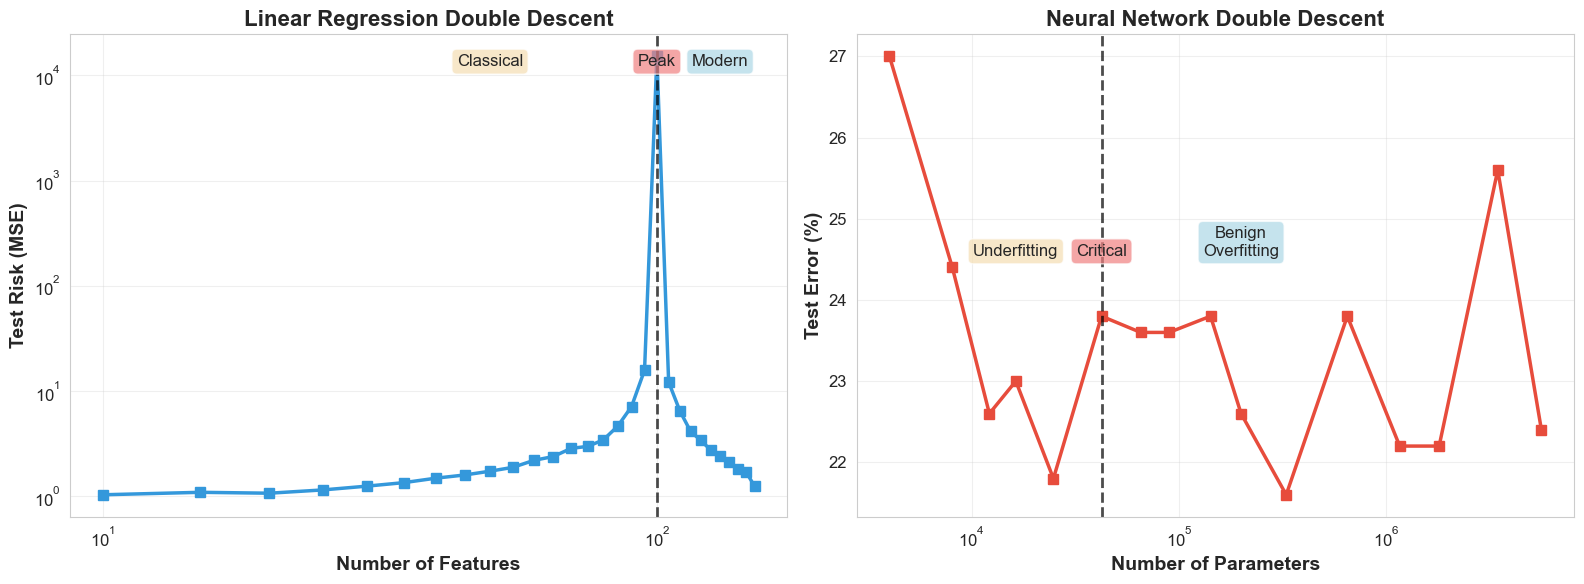

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear regression
ax1 = axes[0]
ax1.plot(results_linear['p_values'], results_linear['test_risks'], 's-',
         linewidth=2.5, markersize=7, color='#3498db', label='Test Risk')
ax1.axvline(x=100, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax1.set_xlabel('Number of Features', fontsize=14, fontweight='bold')
ax1.set_ylabel('Test Risk (MSE)', fontsize=14, fontweight='bold')
ax1.set_title('Linear Regression Double Descent', fontsize=16, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)

# Annotate regions
y_pos = ax1.get_ylim()[1] * 0.5
ax1.text(50, y_pos, 'Classical', fontsize=12, ha='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
ax1.text(100, y_pos, 'Peak', fontsize=12, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
ax1.text(130, y_pos, 'Modern', fontsize=12, ha='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Neural network
ax2 = axes[1]
ax2.plot(nn_params, nn_test_error, 's-', linewidth=2.5, markersize=7,
         color='#e74c3c', label='Test Error')
if interpolation_threshold_idx is not None:
    ax2.axvline(x=nn_params[interpolation_threshold_idx], color='black',
                linestyle='--', linewidth=2, alpha=0.7)
ax2.set_xlabel('Number of Parameters', fontsize=14, fontweight='bold')
ax2.set_ylabel('Test Error (%)', fontsize=14, fontweight='bold')
ax2.set_title('Neural Network Double Descent', fontsize=16, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# Annotate regions
if interpolation_threshold_idx is not None:
    y_pos = ax2.get_ylim()[1] * 0.9
    ax2.text(nn_params[max(0, interpolation_threshold_idx-2)], y_pos,
            'Underfitting', fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    ax2.text(nn_params[interpolation_threshold_idx], y_pos,
            'Critical', fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    ax2.text(nn_params[min(len(nn_params)-1, interpolation_threshold_idx+4)], y_pos,
            'Benign\nOverfitting', fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.savefig('comparison_linear_vs_nn_double_descent.png', dpi=150, bbox_inches='tight')
plt.show()

## Part 4: Save Results

In [13]:
# Save linear regression results
linear_df = pd.DataFrame({
    'p': results_linear['p_values'],
    'train_risk': results_linear['train_risks'],
    'test_risk': results_linear['test_risks'],
    'train_risk_std': results_linear['train_risks_std'],
    'test_risk_std': results_linear['test_risks_std']
})
linear_df.to_csv('linear_double_descent_results.csv', index=False)

# Save neural network results
nn_df = pd.DataFrame({
    'width': widths,
    'parameters': nn_params,
    'train_acc': nn_train_acc,
    'test_acc': nn_test_acc,
    'train_loss': nn_train_loss,
    'test_loss': nn_test_loss,
    'training_time': [r['training_time'] for r in nn_results],
    'epochs': [r['epochs_trained'] for r in nn_results]
})
nn_df.to_csv('neural_network_double_descent_results.csv', index=False)

print("\n" + "="*80)
print("Part 2 Complete!")
print("="*80)
print("\n📁 Generated files:")
print("   • linear_double_descent.png")
print("   • fashion_mnist_samples.png")
print("   • neural_network_double_descent.png")
print("   • neural_network_learning_curves.png")
print("   • comparison_linear_vs_nn_double_descent.png")
print("   • linear_double_descent_results.csv")
print("   • neural_network_double_descent_results.csv")


Part 2 Complete!

📁 Generated files:
   • linear_double_descent.png
   • fashion_mnist_samples.png
   • neural_network_double_descent.png
   • neural_network_learning_curves.png
   • comparison_linear_vs_nn_double_descent.png
   • linear_double_descent_results.csv
   • neural_network_double_descent_results.csv


## Conclusions

### Key Findings

1. **Double Descent is Real**
   - Observed in both linear regression and neural networks
   - Test error decreases → peaks at interpolation → decreases again
   - Contradicts classical bias-variance tradeoff intuition

2. **Interpolation Threshold**
   - Critical point where # parameters ≈ # samples
   - Model can perfectly fit training data (interpolation)
   - Worst generalization occurs here

3. **Benign Overfitting**
   - In overparameterized regime, models generalize well despite interpolating
   - Implicit regularization from optimizer (gradient descent)
   - Minimum-norm solutions tend to be smooth and generalize

### Why Does This Happen?

**Linear Regression:**
- When p < n: Standard least squares
- When p = n: Unique interpolator (often poor generalization)
- When p > n: Many interpolators exist, minimum-norm solution is smooth

**Neural Networks:**
- Small networks: High approximation error (underfitting)
- At threshold: Can barely fit data, sensitive to noise
- Large networks: Many ways to fit data, SGD finds smooth solutions

### Practical Implications

1. **Model Size Matters**
   - Don't be afraid of overparameterization
   - Very large models can generalize well
   - Modern deep learning operates in "benign overfitting" regime

2. **Training Dynamics**
   - How you optimize matters (SGD vs GD)
   - Implicit regularization from optimization
   - Early stopping still useful

3. **Rethinking Regularization**
   - Classical regularization (L2, dropout) may not be necessary
   - Overparameterization itself provides regularization
   - Focus on optimization and architecture

### Connections to Modern Practice

- **Large Language Models**: Billions of parameters, relatively small datasets
- **Vision Transformers**: Massive overparameterization
- **Transfer Learning**: Pre-train large models, fine-tune on small data

The double descent phenomenon helps explain why these approaches work!